In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

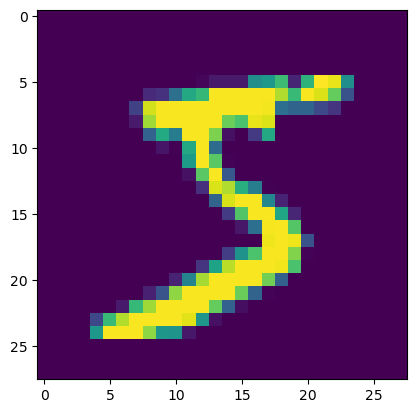

In [3]:
(train_images,train_labels),(test_images,test_labels) = tf.keras.datasets.mnist.load_data()
plt.imshow(train_images[0])

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:

(train_images,train_labels),(test_images,test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images.shape

(60000, 28, 28, 1)

In [6]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [7]:
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]


In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

#train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)


In [11]:
train_dataset


<_TensorSliceDataset element_spec=TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None)>

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
      
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
       
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
     
    return model

In [13]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
      
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
  
    return model

In [14]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [15]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(real_output), logits=real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(generated_output), logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

def generator_loss(generated_output):
    return tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(generated_output), logits = generated_output)  # one cause Gen try to reach one - output of the Dis on fake data 

In [16]:
generator_optimizer = tf.optimizers.Adam(1e-4)  # exponent 0.0001
discriminator_optimizer = tf.optimizers.Adam(1e-4)

In [17]:
noise_dim = 100
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 noise_dim])

In [18]:
random_vector_for_generation

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[-0.76286983, -0.04738804,  0.99468654, ..., -0.05587303,
        -2.0229156 , -0.4048404 ],
       [-0.24059758, -0.06133946, -0.4120858 , ..., -3.067636  ,
         0.03989185, -0.8027529 ],
       [ 0.19126663, -0.70422536, -0.35131294, ..., -0.81817174,
        -0.8883167 , -1.2296193 ],
       ...,
       [-2.8424647 , -0.66684115,  0.4836156 , ..., -0.16654027,
         0.945909  , -0.7258086 ],
       [ 0.4298035 ,  0.47026506,  0.61548555, ..., -0.48646307,
        -0.08398704, -2.1784096 ],
       [ 0.35637665, -0.7661182 ,  0.15166903, ..., -0.8185885 ,
         0.3527585 , -1.3977772 ]], dtype=float32)>

In [19]:
EPOCHS = 50

def train_step(images):
   # generating noise from a normal distribution
    fake_img_noise = tf.random.normal([BATCH_SIZE, noise_dim]).astype("float32")
      
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = make_generator_model(fake_img_noise)
        real_output = make_discriminator_model(images)
        generated_output = make_discriminator_model(generated_images)

        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)


    gradients_of_generator = gen_tape.gradient(gen_loss, make_generator_model.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, make_generator_model.trainable_variables))
        
    gradients_of_discriminator = disc_tape.gradient(disc_loss, make_discriminator_model.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, make_discriminator_model.trainable_variables))

def train(dataset, epochs):  
    for epoch in range(epochs):
      for images in dataset:
        images = tf.cast(images , tf.dtypes.float32)
        train_step(images)    

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define hyperparameters
EPOCHS = 50
BATCH_SIZE = 128
noise_dim = 100
num_examples_to_generate = 16

# Load the MNIST dataset
(x_train, _), (_, _) = keras.datasets.mnist.load_data()
#train_dataset, validation_dataset, test_dataset = keras.datasets.celeba.load_data()


# Normalize the pixel values to be between -1 and 1
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5

# Create a tf.data.Dataset object for the MNIST dataset
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)


# Create the generator and discriminator models
def make_generator_model():
    model = keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) 

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


def make_discriminator_model():
    model = keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the loss functions for the generator and discriminator
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Define the optimizers for the generator and discriminator
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

# Define the training loop
def train_step(images):
    # Generating noise from a normal distribution
    fake_img_noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(fake_img_noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        print("gen_loss" , np.mean(gen_loss))
        print("disc_loss" , np.mean(disc_loss))
        #print("gen_loss" , gen_loss)

# Train the GAN model
def train(dataset, epochs):
    for epoch in range(epochs):
        for batch in dataset:
            train_step(batch)

# Train the GAN model
train(dataset, EPOCHS)

gen_loss tf.Tensor(0.6879811, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3550167, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6668535, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3305125, shape=(), dtype=float32)
gen_loss tf.Tensor(0.652336, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3057142, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6377106, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2828074, shape=(), dtype=float32)
gen_loss tf.Tensor(0.623834, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2542276, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6087275, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2328808, shape=(), dtype=float32)
gen_loss tf.Tensor(0.59746534, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2188386, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5894507, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2011468, shape=(), dtype=float32)
gen_loss tf.Tensor(0.585213, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1737441, shape=(), dtype=float32)
gen

gen_loss tf.Tensor(0.6752832, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0346173, shape=(), dtype=float32)
gen_loss tf.Tensor(0.66574985, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0409707, shape=(), dtype=float32)
gen_loss tf.Tensor(0.66453135, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0085332, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6400322, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0317788, shape=(), dtype=float32)
gen_loss tf.Tensor(0.62594354, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0622433, shape=(), dtype=float32)
gen_loss tf.Tensor(0.60617197, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0984249, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6060754, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0884278, shape=(), dtype=float32)
gen_loss tf.Tensor(0.61361957, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0751908, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6186985, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0708966, shape=(), dtype=float

gen_loss tf.Tensor(1.1947868, shape=(), dtype=float32)
disc_loss tf.Tensor(0.5424706, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1661677, shape=(), dtype=float32)
disc_loss tf.Tensor(0.56883085, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1455978, shape=(), dtype=float32)
disc_loss tf.Tensor(0.6066252, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1045932, shape=(), dtype=float32)
disc_loss tf.Tensor(0.58585674, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1088455, shape=(), dtype=float32)
disc_loss tf.Tensor(0.59697986, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1772332, shape=(), dtype=float32)
disc_loss tf.Tensor(0.5967739, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2358736, shape=(), dtype=float32)
disc_loss tf.Tensor(0.5665263, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3098621, shape=(), dtype=float32)
disc_loss tf.Tensor(0.53837013, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3511759, shape=(), dtype=float32)
disc_loss tf.Tensor(0.5405638, shape=(), dtype=float3

gen_loss tf.Tensor(0.72902334, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3979284, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7353526, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3603644, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72916985, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4304183, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73419815, shape=(), dtype=float32)
disc_loss tf.Tensor(1.342802, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74752593, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3708491, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73172975, shape=(), dtype=float32)
disc_loss tf.Tensor(1.360095, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7344412, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4312301, shape=(), dtype=float32)
gen_loss tf.Tensor(0.727156, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4395678, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7133865, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3927499, shape=(), dtype=float32)

gen_loss tf.Tensor(0.6231251, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5610538, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6290043, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5221651, shape=(), dtype=float32)
gen_loss tf.Tensor(0.59129596, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6696277, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6001049, shape=(), dtype=float32)
disc_loss tf.Tensor(1.633923, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5890003, shape=(), dtype=float32)
disc_loss tf.Tensor(1.691607, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5493964, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6739575, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5318284, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7884152, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5607264, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7478681, shape=(), dtype=float32)
gen_loss tf.Tensor(0.528628, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7911239, shape=(), dtype=float32)
gen

gen_loss tf.Tensor(0.6481951, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7760689, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6613438, shape=(), dtype=float32)
disc_loss tf.Tensor(1.776737, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6544003, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7266256, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6876501, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6270481, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7022567, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5393357, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7313653, shape=(), dtype=float32)
disc_loss tf.Tensor(1.59271, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77745587, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5222981, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7761238, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4760292, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78223985, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5155371, shape=(), dtype=float32)
ge

gen_loss tf.Tensor(0.79104936, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4399168, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7589097, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4977065, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71753573, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6391675, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6696458, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6851776, shape=(), dtype=float32)
gen_loss tf.Tensor(0.601264, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7353553, shape=(), dtype=float32)
gen_loss tf.Tensor(0.57050705, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6058307, shape=(), dtype=float32)
gen_loss tf.Tensor(0.53917825, shape=(), dtype=float32)
disc_loss tf.Tensor(1.9946536, shape=(), dtype=float32)
gen_loss tf.Tensor(0.49849096, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7752501, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5012277, shape=(), dtype=float32)
disc_loss tf.Tensor(1.8214283, shape=(), dtype=float3

gen_loss tf.Tensor(0.8217263, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3871508, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7728109, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4252756, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76929927, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4381907, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77192044, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3956261, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8088048, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4077291, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8336954, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4618134, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78992105, shape=(), dtype=float32)
disc_loss tf.Tensor(1.537075, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7548687, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4371698, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7255087, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4984663, shape=(), dtype=float32)

gen_loss tf.Tensor(0.7961519, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4320861, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72653633, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4221439, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6625183, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4070877, shape=(), dtype=float32)
gen_loss tf.Tensor(0.66772366, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4801155, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71706283, shape=(), dtype=float32)
disc_loss tf.Tensor(1.450038, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7881326, shape=(), dtype=float32)
disc_loss tf.Tensor(1.528191, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7853861, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4867749, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7146654, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5754237, shape=(), dtype=float32)
gen_loss tf.Tensor(0.64645123, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5109334, shape=(), dtype=float32)

gen_loss tf.Tensor(0.84432656, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1998711, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86629415, shape=(), dtype=float32)
disc_loss tf.Tensor(1.135492, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87570214, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2308141, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89555097, shape=(), dtype=float32)
disc_loss tf.Tensor(1.207044, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91371304, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1767731, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83714, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2841258, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80442965, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2639349, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8113214, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2555692, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78994286, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3192345, shape=(), dtype=float32

gen_loss tf.Tensor(0.74788654, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4701169, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7268634, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4437921, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6858384, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5043257, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6911706, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4567755, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6855283, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4352016, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69336486, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4841278, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74078906, shape=(), dtype=float32)
disc_loss tf.Tensor(1.50349, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71592695, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5110497, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7029637, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5288668, shape=(), dtype=float32)

gen_loss tf.Tensor(0.79267335, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1642025, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80523646, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1240683, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86944306, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0888668, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87176836, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0579815, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9757688, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0690999, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9266997, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0570946, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9589584, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0786709, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9414051, shape=(), dtype=float32)
disc_loss tf.Tensor(1.036346, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8963845, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0299704, shape=(), dtype=float32

gen_loss tf.Tensor(0.9819604, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0170429, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0189906, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0121825, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9959441, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97957885, shape=(), dtype=float32)
gen_loss tf.Tensor(1.027369, shape=(), dtype=float32)
disc_loss tf.Tensor(0.96631384, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0269055, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9713315, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0653554, shape=(), dtype=float32)
disc_loss tf.Tensor(0.929683, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0593551, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9662583, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0968279, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94981843, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0642241, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9584166, shape=(), dtype=float32)


gen_loss tf.Tensor(0.6533172, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5550625, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73875356, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4162879, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74028367, shape=(), dtype=float32)
disc_loss tf.Tensor(1.530756, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7166438, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6028686, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70412874, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5756719, shape=(), dtype=float32)
gen_loss tf.Tensor(0.63800466, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6178035, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6398764, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5663089, shape=(), dtype=float32)
gen_loss tf.Tensor(0.66282356, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6482989, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67673725, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6578965, shape=(), dtype=float

gen_loss tf.Tensor(1.014252, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1120193, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0318711, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1515692, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0389616, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1208546, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99373186, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1170404, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95497465, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1979604, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9475193, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1530769, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9126053, shape=(), dtype=float32)
disc_loss tf.Tensor(1.172013, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91071916, shape=(), dtype=float32)
disc_loss tf.Tensor(1.276063, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9967501, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1854614, shape=(), dtype=float32)
g

gen_loss tf.Tensor(0.7146186, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3703969, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7738838, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2926762, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7890127, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2897797, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8875313, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3212792, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8547037, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3314177, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87435794, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1588068, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9021331, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2304606, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81777143, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2762966, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84860474, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2327312, shape=(), dtype=float32

gen_loss tf.Tensor(0.8146732, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4676197, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8181056, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5023754, shape=(), dtype=float32)
gen_loss tf.Tensor(0.739625, shape=(), dtype=float32)
disc_loss tf.Tensor(1.555934, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6943518, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6291376, shape=(), dtype=float32)
gen_loss tf.Tensor(0.716105, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7332201, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6995162, shape=(), dtype=float32)
disc_loss tf.Tensor(1.624116, shape=(), dtype=float32)
gen_loss tf.Tensor(0.62049806, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7503593, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6581844, shape=(), dtype=float32)
disc_loss tf.Tensor(1.816719, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5918782, shape=(), dtype=float32)
disc_loss tf.Tensor(1.8530376, shape=(), dtype=float32)
gen_l

gen_loss tf.Tensor(0.6663054, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6435022, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6773546, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7503678, shape=(), dtype=float32)
gen_loss tf.Tensor(0.66054225, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6373831, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7407752, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7422993, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7133684, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6708013, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80711293, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7059213, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7702071, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7015247, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72764635, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6964037, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7164544, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5557435, shape=(), dtype=float32

gen_loss tf.Tensor(0.6390718, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5514883, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7051308, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4941161, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6836686, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5739167, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73840266, shape=(), dtype=float32)
disc_loss tf.Tensor(1.527328, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71173817, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5420699, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72096646, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5883434, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7072513, shape=(), dtype=float32)
disc_loss tf.Tensor(1.614841, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70697755, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5374165, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6838336, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5919349, shape=(), dtype=float32)

gen_loss tf.Tensor(0.767632, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3975353, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7859818, shape=(), dtype=float32)
disc_loss tf.Tensor(1.361374, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7586739, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4104962, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7564341, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3800745, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76107365, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4473054, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7590009, shape=(), dtype=float32)
disc_loss tf.Tensor(1.481288, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7479582, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4471116, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7391741, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4243165, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74668825, shape=(), dtype=float32)
disc_loss tf.Tensor(1.391146, shape=(), dtype=float32)
gen

gen_loss tf.Tensor(1.0574319, shape=(), dtype=float32)
disc_loss tf.Tensor(1.007008, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0125632, shape=(), dtype=float32)
disc_loss tf.Tensor(0.98917496, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0356017, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0359733, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0381162, shape=(), dtype=float32)
disc_loss tf.Tensor(1.022258, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0413247, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0164082, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0396565, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0829201, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9942333, shape=(), dtype=float32)
disc_loss tf.Tensor(1.112917, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97773397, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1027832, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9530285, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0842168, shape=(), dtype=float32)
ge

gen_loss tf.Tensor(0.6287292, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5286996, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6338089, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5383161, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6991652, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5177526, shape=(), dtype=float32)
gen_loss tf.Tensor(0.697148, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5566132, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7269562, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4803817, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7320177, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5773244, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70243317, shape=(), dtype=float32)
disc_loss tf.Tensor(1.552526, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7030454, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5286512, shape=(), dtype=float32)
gen_loss tf.Tensor(0.64958227, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5291334, shape=(), dtype=float32)
g

gen_loss tf.Tensor(1.0240037, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9828967, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0371938, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9806037, shape=(), dtype=float32)
gen_loss tf.Tensor(1.077277, shape=(), dtype=float32)
disc_loss tf.Tensor(0.96319926, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1071832, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9785537, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0856626, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94876814, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0436176, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9927881, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0737355, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9951902, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0153136, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9631361, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99268216, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0368612, shape=(), dtype=float32)

gen_loss tf.Tensor(0.7178971, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3721043, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79189515, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2749069, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8525914, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3281299, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8966198, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3200884, shape=(), dtype=float32)
gen_loss tf.Tensor(0.846597, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3887379, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8372317, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3846695, shape=(), dtype=float32)
gen_loss tf.Tensor(0.772703, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4022821, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7050313, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3615701, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70358294, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3521075, shape=(), dtype=float32)
g

gen_loss tf.Tensor(1.1017736, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9328915, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0472977, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9714905, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0902714, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9056796, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0584869, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9772687, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1718447, shape=(), dtype=float32)
disc_loss tf.Tensor(0.92172724, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1632175, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9964969, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1794995, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9723784, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0733112, shape=(), dtype=float32)
disc_loss tf.Tensor(0.98765177, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0198736, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97587687, shape=(), dtype=float32

gen_loss tf.Tensor(0.8766642, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2329365, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8841094, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2477198, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87918115, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2036616, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8924493, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1894333, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8586621, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1381205, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91213286, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1433526, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91061413, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2497668, shape=(), dtype=float32)
gen_loss tf.Tensor(0.902061, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1642756, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8850811, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1948878, shape=(), dtype=float32)

gen_loss tf.Tensor(0.8145403, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4134839, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8305507, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3880607, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8206338, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2911048, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8072773, shape=(), dtype=float32)
disc_loss tf.Tensor(1.360733, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83177483, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2696155, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82024634, shape=(), dtype=float32)
disc_loss tf.Tensor(1.29672, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8605515, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2289593, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86171705, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2426102, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8769376, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1940385, shape=(), dtype=float32)
g

gen_loss tf.Tensor(0.6922661, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5153694, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67512584, shape=(), dtype=float32)
disc_loss tf.Tensor(1.564338, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6856928, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5201985, shape=(), dtype=float32)
gen_loss tf.Tensor(0.61070454, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6585102, shape=(), dtype=float32)
gen_loss tf.Tensor(0.61740327, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5565665, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67769414, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5053996, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6906883, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5093825, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7179086, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5970585, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74580705, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5111581, shape=(), dtype=float3

gen_loss tf.Tensor(0.9053831, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1260381, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89878356, shape=(), dtype=float32)
disc_loss tf.Tensor(1.26229, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9881538, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1661723, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9833607, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1521864, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9674361, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2011081, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9369514, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1268703, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96953714, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1606731, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9347358, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1230123, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9744992, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0358236, shape=(), dtype=float32)
g

gen_loss tf.Tensor(0.69649863, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4896384, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72883093, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4510127, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70564526, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4744474, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7220107, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4672644, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67107403, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5458013, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72178674, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4541266, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7818055, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5330367, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72472566, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4420564, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72204375, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3892375, shape=(), dtype=flo

gen_loss tf.Tensor(1.0096517, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1729801, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9686657, shape=(), dtype=float32)
disc_loss tf.Tensor(1.224841, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9634819, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2484734, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90200126, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2288886, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8545474, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2541208, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8866566, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2566147, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96278006, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1558633, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9858259, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1791568, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9211769, shape=(), dtype=float32)
disc_loss tf.Tensor(1.192294, shape=(), dtype=float32)
g

gen_loss tf.Tensor(0.8958353, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2496524, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9715771, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1957242, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9388268, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2082868, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95254326, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2014989, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8931781, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1820233, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85143155, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1564245, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86511564, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1700443, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9640984, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1694814, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9819937, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1568265, shape=(), dtype=float32

gen_loss tf.Tensor(0.9362534, shape=(), dtype=float32)
disc_loss tf.Tensor(1.155865, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9930694, shape=(), dtype=float32)
disc_loss tf.Tensor(1.160391, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9416317, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2423561, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8345115, shape=(), dtype=float32)
disc_loss tf.Tensor(1.179214, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8519023, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2738636, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9083661, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2672396, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9585088, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3402401, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9390584, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2516531, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87956977, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3264139, shape=(), dtype=float32)
gen

gen_loss tf.Tensor(1.234846, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8502876, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2751914, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8224233, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2110071, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8307278, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1947515, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8258026, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1606889, shape=(), dtype=float32)
disc_loss tf.Tensor(0.83301276, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1893332, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8065899, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1943607, shape=(), dtype=float32)
disc_loss tf.Tensor(0.81662095, shape=(), dtype=float32)
gen_loss tf.Tensor(1.185825, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8636341, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2131469, shape=(), dtype=float32)
disc_loss tf.Tensor(0.79675734, shape=(), dtype=float32)


gen_loss tf.Tensor(0.98445374, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1609602, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95459056, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1760983, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93460417, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2612584, shape=(), dtype=float32)
gen_loss tf.Tensor(0.960837, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2801566, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9356724, shape=(), dtype=float32)
disc_loss tf.Tensor(1.230123, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9395385, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2907228, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9787922, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1909461, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9580053, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2919554, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9343648, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2910075, shape=(), dtype=float32)


gen_loss tf.Tensor(1.1218944, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0487175, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0846798, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0435752, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1017425, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0264945, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0755879, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0381589, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0655038, shape=(), dtype=float32)
disc_loss tf.Tensor(1.009742, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0537405, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0211813, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0527713, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0480016, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0529433, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1340723, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1314595, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0693134, shape=(), dtype=float32)
ge

gen_loss tf.Tensor(0.97162557, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1587616, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98998064, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2048054, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0288395, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1492889, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0096027, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2123766, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9395379, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2596614, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95337474, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2939295, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8802868, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3415985, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92809296, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3594033, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9583841, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4374368, shape=(), dtype=float3

gen_loss tf.Tensor(1.0454171, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3647873, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98379517, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3954896, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9982783, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3988589, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8525109, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4589138, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87052023, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4278324, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9010067, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4268119, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83268595, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6639677, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76474965, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6696, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76847255, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5762926, shape=(), dtype=float32)

gen_loss tf.Tensor(0.8391232, shape=(), dtype=float32)
disc_loss tf.Tensor(1.464639, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8831228, shape=(), dtype=float32)
disc_loss tf.Tensor(1.355679, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8949083, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5436262, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8515108, shape=(), dtype=float32)
disc_loss tf.Tensor(1.501521, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8581707, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5685995, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79917336, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5913825, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7081824, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5905201, shape=(), dtype=float32)
gen_loss tf.Tensor(0.66896874, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6337008, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7219188, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5839515, shape=(), dtype=float32)
ge

gen_loss tf.Tensor(1.0181394, shape=(), dtype=float32)
disc_loss tf.Tensor(1.166293, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9871621, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2022158, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88214916, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2666731, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9202415, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1104472, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9259398, shape=(), dtype=float32)
disc_loss tf.Tensor(1.26591, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92057157, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2870324, shape=(), dtype=float32)
gen_loss tf.Tensor(1.107561, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3194695, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0272974, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3653781, shape=(), dtype=float32)
gen_loss tf.Tensor(0.991025, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3896102, shape=(), dtype=float32)
gen_

gen_loss tf.Tensor(0.88955724, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4025307, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82991934, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4123181, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7829523, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4244618, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7728696, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4306593, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92497414, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5890616, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98520875, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5339963, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9441675, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6239388, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9042113, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5681384, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8360146, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6437626, shape=(), dtype=float3

gen_loss tf.Tensor(1.0556442, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0472147, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9158983, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0460367, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9012315, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0306776, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96500415, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1031549, shape=(), dtype=float32)
gen_loss tf.Tensor(1.021493, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0998058, shape=(), dtype=float32)
gen_loss tf.Tensor(1.154821, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1314214, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1342931, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1313827, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0039403, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1429203, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87733924, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1611236, shape=(), dtype=float32)
g

gen_loss tf.Tensor(0.8915609, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3189435, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88101393, shape=(), dtype=float32)
disc_loss tf.Tensor(1.389708, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8333997, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3942816, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77713954, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3742063, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83691514, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4023855, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9680634, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3928819, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93545604, shape=(), dtype=float32)
disc_loss tf.Tensor(1.484051, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85973716, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4923167, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7644096, shape=(), dtype=float32)
disc_loss tf.Tensor(1.523611, shape=(), dtype=float32)

gen_loss tf.Tensor(1.1211345, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9602323, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1318245, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9248945, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1435508, shape=(), dtype=float32)
disc_loss tf.Tensor(0.90476084, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1489639, shape=(), dtype=float32)
disc_loss tf.Tensor(0.90782744, shape=(), dtype=float32)
gen_loss tf.Tensor(1.04371, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9507797, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0933264, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9647405, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1570449, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9142325, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1725476, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9290565, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1053023, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0418369, shape=(), dtype=float32)
g

gen_loss tf.Tensor(0.87278247, shape=(), dtype=float32)
disc_loss tf.Tensor(1.237432, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89291465, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1481094, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90403175, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2644017, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96813506, shape=(), dtype=float32)
disc_loss tf.Tensor(1.272912, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9418298, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2126098, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0394199, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0867667, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9848998, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1773543, shape=(), dtype=float32)
gen_loss tf.Tensor(0.935107, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1828792, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96009, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1293585, shape=(), dtype=float32)
ge

gen_loss tf.Tensor(1.021637, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0747397, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0201173, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0184888, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0356672, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0841383, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1086781, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0268352, shape=(), dtype=float32)
gen_loss tf.Tensor(1.044409, shape=(), dtype=float32)
disc_loss tf.Tensor(0.98822045, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9850491, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0281357, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0765157, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97721756, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0617449, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99512273, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1200602, shape=(), dtype=float32)
disc_loss tf.Tensor(1.077181, shape=(), dtype=float32)
g

gen_loss tf.Tensor(1.0421193, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1357251, shape=(), dtype=float32)
gen_loss tf.Tensor(1.053884, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1172794, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0009301, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1214888, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0152063, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1267321, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9979333, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0716088, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0064375, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1519544, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0250123, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0765648, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0656316, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1170261, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0264201, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1832532, shape=(), dtype=float32)
ge

gen_loss tf.Tensor(1.0231335, shape=(), dtype=float32)
disc_loss tf.Tensor(1.162939, shape=(), dtype=float32)
gen_loss tf.Tensor(1.099395, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2907209, shape=(), dtype=float32)
gen_loss tf.Tensor(1.03882, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1695446, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8866613, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1929712, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8173979, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2032844, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92393696, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1471537, shape=(), dtype=float32)
gen_loss tf.Tensor(0.979, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2583454, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0592172, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2093688, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0633464, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1699607, shape=(), dtype=float32)
gen_loss

gen_loss tf.Tensor(0.9547696, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4476296, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82971716, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3091094, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9037372, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2936075, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78417206, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4003515, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9843033, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2193224, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9753006, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3657633, shape=(), dtype=float32)
gen_loss tf.Tensor(1.003134, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3465998, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9360708, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2608919, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9030695, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1655905, shape=(), dtype=float32)


gen_loss tf.Tensor(0.8714802, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2040887, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90911835, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2508905, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97101355, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2048976, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0508819, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2043686, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9862218, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2736046, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0063105, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1959665, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87684524, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1723614, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8314885, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2418114, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96082646, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1495945, shape=(), dtype=float3

gen_loss tf.Tensor(1.1652247, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0522666, shape=(), dtype=float32)
gen_loss tf.Tensor(1.279046, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0336292, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2582443, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0433632, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0592842, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0119008, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0119915, shape=(), dtype=float32)
disc_loss tf.Tensor(1.042378, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98782206, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0517924, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1547594, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0285932, shape=(), dtype=float32)
gen_loss tf.Tensor(1.162477, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0077263, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2689537, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9714335, shape=(), dtype=float32)
gen

gen_loss tf.Tensor(1.0373648, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0737857, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0461264, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1013898, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1771781, shape=(), dtype=float32)
disc_loss tf.Tensor(1.110397, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1979434, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0687873, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1591196, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9870073, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0895302, shape=(), dtype=float32)
disc_loss tf.Tensor(1.025811, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0608461, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0308056, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1183383, shape=(), dtype=float32)
disc_loss tf.Tensor(1.085459, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0652924, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0817204, shape=(), dtype=float32)
gen_

gen_loss tf.Tensor(1.4090185, shape=(), dtype=float32)
disc_loss tf.Tensor(0.90996236, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3026346, shape=(), dtype=float32)
disc_loss tf.Tensor(1.058872, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3488982, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0773641, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2034508, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0889089, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9879762, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1755319, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8599251, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2538804, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0106769, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2899902, shape=(), dtype=float32)
gen_loss tf.Tensor(1.087733, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1514997, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1059899, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3678396, shape=(), dtype=float32)
ge

gen_loss tf.Tensor(1.0435612, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3695819, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0223879, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2707798, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92031425, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3629562, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99617827, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2666593, shape=(), dtype=float32)
gen_loss tf.Tensor(1.088355, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2522354, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1286215, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2377105, shape=(), dtype=float32)
gen_loss tf.Tensor(1.136986, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2145139, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1867712, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2338245, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0389754, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1516838, shape=(), dtype=float32)
g

gen_loss tf.Tensor(0.9797297, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1127504, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0264924, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0642307, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0859313, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1663879, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2081714, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0256398, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2435355, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0689119, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2072394, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0762703, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1166258, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0764312, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0596895, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0292228, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9966587, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0730157, shape=(), dtype=float32)
g

gen_loss tf.Tensor(1.072184, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0891882, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0744412, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1439071, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9544706, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1472709, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95946646, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1378579, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0418446, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1822988, shape=(), dtype=float32)
gen_loss tf.Tensor(1.14148, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1208239, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1794648, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1551068, shape=(), dtype=float32)
gen_loss tf.Tensor(1.118051, shape=(), dtype=float32)
disc_loss tf.Tensor(1.237825, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0123398, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2100694, shape=(), dtype=float32)
gen_l

gen_loss tf.Tensor(1.0186081, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0399132, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0901217, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0417325, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1147611, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1005819, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0349426, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1145775, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0851209, shape=(), dtype=float32)
disc_loss tf.Tensor(0.98894596, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0226576, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0590808, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0158241, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0788409, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1305779, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0344424, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0416441, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0203882, shape=(), dtype=float32)


gen_loss tf.Tensor(1.0588593, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0931945, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3006502, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1216162, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1263669, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0840193, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97447956, shape=(), dtype=float32)
disc_loss tf.Tensor(1.202097, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1300069, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1304852, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0084169, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1837461, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0352892, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0873467, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1169188, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2074289, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1580484, shape=(), dtype=float32)
disc_loss tf.Tensor(1.133111, shape=(), dtype=float32)
ge

gen_loss tf.Tensor(1.0767958, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1436348, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0488831, shape=(), dtype=float32)
disc_loss tf.Tensor(1.378506, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99493945, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3465354, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9807242, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3871038, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8757308, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2465228, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80880195, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3100065, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0534009, shape=(), dtype=float32)
disc_loss tf.Tensor(1.321131, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1998589, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2506697, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1771287, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2953533, shape=(), dtype=float32)
g

gen_loss tf.Tensor(1.5969794, shape=(), dtype=float32)
disc_loss tf.Tensor(0.7487705, shape=(), dtype=float32)
gen_loss tf.Tensor(1.5759554, shape=(), dtype=float32)
disc_loss tf.Tensor(0.82094246, shape=(), dtype=float32)
gen_loss tf.Tensor(1.5371335, shape=(), dtype=float32)
disc_loss tf.Tensor(0.82376754, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3909285, shape=(), dtype=float32)
disc_loss tf.Tensor(0.84794676, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3074749, shape=(), dtype=float32)
disc_loss tf.Tensor(0.82149816, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3343513, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8334542, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3815649, shape=(), dtype=float32)
disc_loss tf.Tensor(0.88641, shape=(), dtype=float32)
gen_loss tf.Tensor(1.5198607, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8480426, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3437357, shape=(), dtype=float32)
disc_loss tf.Tensor(0.80515474, shape=(), dtype=float32

gen_loss tf.Tensor(1.1711271, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0573115, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1645687, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0744424, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0955036, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1713829, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0580931, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97911763, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1505504, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0950456, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3266845, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0315555, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4825621, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97852665, shape=(), dtype=float32)
gen_loss tf.Tensor(1.19926, shape=(), dtype=float32)
disc_loss tf.Tensor(0.98783106, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0957425, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9593936, shape=(), dtype=float32)


gen_loss tf.Tensor(1.2113463, shape=(), dtype=float32)
disc_loss tf.Tensor(0.95400083, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1660063, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0085723, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3017293, shape=(), dtype=float32)
disc_loss tf.Tensor(0.814831, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2026176, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8436298, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3487568, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8592492, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4016047, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9326016, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3387941, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9481289, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2882485, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0097921, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1540267, shape=(), dtype=float32)
disc_loss tf.Tensor(0.93442655, shape=(), dtype=float32)


gen_loss tf.Tensor(0.9154475, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2279758, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0845068, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1042105, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1542798, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1956822, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2712628, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1056802, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2864108, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1646961, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2334745, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0568569, shape=(), dtype=float32)
gen_loss tf.Tensor(1.24562, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0374309, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0671008, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0466987, shape=(), dtype=float32)
gen_loss tf.Tensor(1.137042, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0693314, shape=(), dtype=float32)
gen_

gen_loss tf.Tensor(1.1712129, shape=(), dtype=float32)
disc_loss tf.Tensor(0.91025025, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3581415, shape=(), dtype=float32)
disc_loss tf.Tensor(0.93857884, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3550979, shape=(), dtype=float32)
disc_loss tf.Tensor(1.031512, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3588264, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9836532, shape=(), dtype=float32)
gen_loss tf.Tensor(1.382849, shape=(), dtype=float32)
disc_loss tf.Tensor(0.92964077, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1213615, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0162053, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0861043, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9805158, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1540216, shape=(), dtype=float32)
disc_loss tf.Tensor(0.96413505, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2717383, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99173987, shape=(), dtype=float32

gen_loss tf.Tensor(0.79823035, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2475994, shape=(), dtype=float32)
gen_loss tf.Tensor(0.869125, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1547511, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1386807, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0834978, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3501147, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1797112, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2877789, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1586728, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0979269, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0753465, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8935908, shape=(), dtype=float32)
disc_loss tf.Tensor(1.248796, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9228468, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2242785, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9927379, shape=(), dtype=float32)
disc_loss tf.Tensor(1.134979, shape=(), dtype=float32)
gen

gen_loss tf.Tensor(1.2661327, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9106873, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3218, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0446482, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3491983, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0670328, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3368909, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8604102, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0530046, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0188485, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1119292, shape=(), dtype=float32)
disc_loss tf.Tensor(0.98158693, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2826898, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9722551, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1852648, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9699696, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1476939, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1131241, shape=(), dtype=float32)
gen

gen_loss tf.Tensor(1.2027633, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0168762, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3539903, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99119735, shape=(), dtype=float32)
gen_loss tf.Tensor(1.298082, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8981053, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2754924, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9760684, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2108858, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9524882, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1486136, shape=(), dtype=float32)
disc_loss tf.Tensor(0.98412913, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2232616, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9334583, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1894299, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0542023, shape=(), dtype=float32)
gen_loss tf.Tensor(1.220134, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0733621, shape=(), dtype=float32)
g

gen_loss tf.Tensor(1.3087488, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0258989, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2635068, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1358161, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3744152, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1879582, shape=(), dtype=float32)
gen_loss tf.Tensor(1.190346, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1966053, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96934676, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2019224, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9955636, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1077821, shape=(), dtype=float32)
gen_loss tf.Tensor(1.10878, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2085835, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3511069, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2291688, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2742715, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1609111, shape=(), dtype=float32)
gen

gen_loss tf.Tensor(1.2570953, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9837804, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0797617, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9629687, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1005528, shape=(), dtype=float32)
disc_loss tf.Tensor(1.018643, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2490208, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9328476, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3304043, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9330339, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3083422, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8787961, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3037552, shape=(), dtype=float32)
disc_loss tf.Tensor(0.95899713, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3023764, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0051713, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1644351, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0455323, shape=(), dtype=float32)
g

gen_loss tf.Tensor(0.8739828, shape=(), dtype=float32)
disc_loss tf.Tensor(1.193801, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9533721, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1086935, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0521402, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0807703, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2613785, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1543617, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1501491, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0793788, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0896112, shape=(), dtype=float32)
disc_loss tf.Tensor(1.070727, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0891492, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0111597, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95138836, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0629791, shape=(), dtype=float32)
gen_loss tf.Tensor(1.019032, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0465809, shape=(), dtype=float32)
gen

gen_loss tf.Tensor(1.3306217, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0182147, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3878827, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8896411, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2428672, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9807816, shape=(), dtype=float32)
gen_loss tf.Tensor(1.183526, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9142509, shape=(), dtype=float32)
gen_loss tf.Tensor(1.258385, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8656769, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4203895, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8955607, shape=(), dtype=float32)
gen_loss tf.Tensor(1.589996, shape=(), dtype=float32)
disc_loss tf.Tensor(0.91035986, shape=(), dtype=float32)
gen_loss tf.Tensor(1.416604, shape=(), dtype=float32)
disc_loss tf.Tensor(0.7930654, shape=(), dtype=float32)
gen_loss tf.Tensor(1.334303, shape=(), dtype=float32)
disc_loss tf.Tensor(0.82035524, shape=(), dtype=float32)
gen_

gen_loss tf.Tensor(1.2211131, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0688579, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1652346, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1226146, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1290195, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1065974, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2361112, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1241782, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2272598, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97763157, shape=(), dtype=float32)
gen_loss tf.Tensor(1.291125, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97663856, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2594886, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0776392, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3213531, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0767804, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2944409, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1433702, shape=(), dtype=float32)


gen_loss tf.Tensor(0.93015146, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1711115, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9462154, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0580965, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0476539, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1346971, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1743319, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1561931, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2870746, shape=(), dtype=float32)
disc_loss tf.Tensor(1.181987, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2054007, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1345762, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1028378, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1171994, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0253626, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1274567, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0918965, shape=(), dtype=float32)
disc_loss tf.Tensor(1.154639, shape=(), dtype=float32)
ge

gen_loss tf.Tensor(1.2180008, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9568429, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2710395, shape=(), dtype=float32)
disc_loss tf.Tensor(0.96891654, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2800086, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0522302, shape=(), dtype=float32)
gen_loss tf.Tensor(1.11248, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0302548, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3217995, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0000652, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1381989, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9881427, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0982785, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0208, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2022728, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9167654, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2229724, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0680662, shape=(), dtype=float32)
gen_l

gen_loss tf.Tensor(1.0717106, shape=(), dtype=float32)
disc_loss tf.Tensor(1.206697, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0700831, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1094816, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95696354, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1382651, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0118479, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1226408, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0514743, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0730441, shape=(), dtype=float32)
gen_loss tf.Tensor(1.039963, shape=(), dtype=float32)
disc_loss tf.Tensor(1.087632, shape=(), dtype=float32)
gen_loss tf.Tensor(1.005147, shape=(), dtype=float32)
disc_loss tf.Tensor(1.191819, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0645399, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0056949, shape=(), dtype=float32)
gen_loss tf.Tensor(1.094806, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1522183, shape=(), dtype=float32)
gen_lo

gen_loss tf.Tensor(1.248656, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0499972, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3209697, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0142863, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3516426, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0270165, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2819997, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0413365, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1413943, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9723883, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1831172, shape=(), dtype=float32)
disc_loss tf.Tensor(1.04245, shape=(), dtype=float32)
gen_loss tf.Tensor(1.320483, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9972682, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3351355, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1055193, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2138479, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0561763, shape=(), dtype=float32)
gen_l

gen_loss tf.Tensor(1.297093, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3190194, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0953159, shape=(), dtype=float32)
disc_loss tf.Tensor(1.165929, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1502051, shape=(), dtype=float32)
disc_loss tf.Tensor(1.184011, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0015593, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3078209, shape=(), dtype=float32)
gen_loss tf.Tensor(0.953827, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2440538, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0439098, shape=(), dtype=float32)
disc_loss tf.Tensor(1.281837, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99622893, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3641539, shape=(), dtype=float32)
gen_loss tf.Tensor(1.110055, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2056043, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0238473, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2701688, shape=(), dtype=float32)
gen_lo

gen_loss tf.Tensor(1.3644058, shape=(), dtype=float32)
disc_loss tf.Tensor(1.014041, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2573471, shape=(), dtype=float32)
disc_loss tf.Tensor(1.059355, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2455605, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0673882, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3507655, shape=(), dtype=float32)
disc_loss tf.Tensor(0.936278, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0664669, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1219435, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0757883, shape=(), dtype=float32)
disc_loss tf.Tensor(1.089685, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1338304, shape=(), dtype=float32)
disc_loss tf.Tensor(1.015863, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2647249, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9987484, shape=(), dtype=float32)
gen_loss tf.Tensor(1.196712, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1633868, shape=(), dtype=float32)
gen_los

gen_loss tf.Tensor(1.1865451, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0302942, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0012004, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1220754, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0497642, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1717045, shape=(), dtype=float32)
gen_loss tf.Tensor(1.016731, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0985653, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1321836, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0930827, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2816927, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0488064, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1256471, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1093078, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2315552, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0251963, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1169487, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1086413, shape=(), dtype=float32)
ge

gen_loss tf.Tensor(1.1302537, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2500545, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2473695, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2943553, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1585467, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2069513, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9434193, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2453104, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0038347, shape=(), dtype=float32)
disc_loss tf.Tensor(1.145189, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0981762, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1474756, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1823492, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2431761, shape=(), dtype=float32)
gen_loss tf.Tensor(1.215488, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2023063, shape=(), dtype=float32)
gen_loss tf.Tensor(1.227644, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1089516, shape=(), dtype=float32)
gen_

gen_loss tf.Tensor(1.1749594, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2822562, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0016558, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2390538, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0314856, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1683656, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0783896, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1021614, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0018085, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2106065, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1444436, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1766804, shape=(), dtype=float32)
gen_loss tf.Tensor(1.225414, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1779948, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0302525, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2133405, shape=(), dtype=float32)
gen_loss tf.Tensor(1.106077, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0965664, shape=(), dtype=float32)
gen

gen_loss tf.Tensor(1.2536371, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1121106, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2585413, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1265705, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2005404, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0376127, shape=(), dtype=float32)
gen_loss tf.Tensor(1.096095, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0861909, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0283848, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2580879, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1757656, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1856041, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2873878, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1576892, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1209686, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1749446, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0693977, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1642641, shape=(), dtype=float32)
ge

gen_loss tf.Tensor(1.2490873, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9488326, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3266155, shape=(), dtype=float32)
disc_loss tf.Tensor(0.87938637, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3087718, shape=(), dtype=float32)
disc_loss tf.Tensor(0.88500535, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1694593, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9563384, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3151243, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8723368, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2217212, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9380034, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2252784, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9084288, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2011797, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9152187, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3029706, shape=(), dtype=float32)
disc_loss tf.Tensor(0.81661564, shape=(), dtype=float32

gen_loss tf.Tensor(1.3049729, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2679603, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0548604, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2406158, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93462455, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2263672, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97658104, shape=(), dtype=float32)
disc_loss tf.Tensor(1.27888, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2142125, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2309964, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1786765, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3208857, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0838147, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1926761, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98431695, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2138534, shape=(), dtype=float32)
gen_loss tf.Tensor(1.043417, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2232738, shape=(), dtype=float32)
g

gen_loss tf.Tensor(1.1360097, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0144138, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2009284, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99875665, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1305056, shape=(), dtype=float32)
disc_loss tf.Tensor(1.115715, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1967696, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0074775, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1559876, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0529034, shape=(), dtype=float32)
gen_loss tf.Tensor(1.16826, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0104622, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1869097, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0044167, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2712508, shape=(), dtype=float32)
disc_loss tf.Tensor(1.01277, shape=(), dtype=float32)
gen_loss tf.Tensor(1.349729, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0206184, shape=(), dtype=float32)
gen_lo

gen_loss tf.Tensor(1.1543603, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0887611, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0499907, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2279375, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9827498, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1619123, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0623825, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3135493, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2266341, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1925102, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0925931, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3652729, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0826733, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2559297, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0878525, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2073336, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9793498, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3551059, shape=(), dtype=float32)
g

gen_loss tf.Tensor(1.3096706, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9487233, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4087123, shape=(), dtype=float32)
disc_loss tf.Tensor(1.009345, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3652186, shape=(), dtype=float32)
disc_loss tf.Tensor(0.92689925, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2189506, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9315842, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1586082, shape=(), dtype=float32)
disc_loss tf.Tensor(0.87838656, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1112902, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9733656, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3103836, shape=(), dtype=float32)
disc_loss tf.Tensor(0.89973927, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4530897, shape=(), dtype=float32)
disc_loss tf.Tensor(0.92413044, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4749148, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9259561, shape=(), dtype=float32

gen_loss tf.Tensor(0.9103686, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2013235, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99863565, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2345736, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0111455, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3104947, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0999722, shape=(), dtype=float32)
disc_loss tf.Tensor(1.349746, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0040822, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2294462, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9502604, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3296928, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0303245, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4249672, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9320471, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2950435, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9755522, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3513136, shape=(), dtype=float32)
g

gen_loss tf.Tensor(1.184694, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0103512, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2212408, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9645834, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0811129, shape=(), dtype=float32)
disc_loss tf.Tensor(0.96007323, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1659652, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9322346, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2786704, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9750767, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4747062, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9508505, shape=(), dtype=float32)
gen_loss tf.Tensor(1.606436, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9042465, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4761992, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9592312, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3074982, shape=(), dtype=float32)
disc_loss tf.Tensor(0.89074814, shape=(), dtype=float32)
g

gen_loss tf.Tensor(0.8650277, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3912637, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78892434, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3476539, shape=(), dtype=float32)
gen_loss tf.Tensor(0.970551, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2596889, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98765314, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3442123, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0908489, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3365958, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0395322, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2892072, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81340206, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4429007, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84817487, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2309692, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9664539, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2825305, shape=(), dtype=float32

gen_loss tf.Tensor(1.1610932, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9599384, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3480307, shape=(), dtype=float32)
disc_loss tf.Tensor(0.92100394, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4060837, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8969811, shape=(), dtype=float32)
gen_loss tf.Tensor(1.5202825, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8787639, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3091295, shape=(), dtype=float32)
disc_loss tf.Tensor(0.91441154, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2574246, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9142394, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0935105, shape=(), dtype=float32)
disc_loss tf.Tensor(0.90956813, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1041734, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94591475, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1845667, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9126488, shape=(), dtype=float3

gen_loss tf.Tensor(1.1533172, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3284655, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8674731, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3928177, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7509859, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5048146, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0497913, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3056173, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9835099, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3570386, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2157443, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1980824, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2332299, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1973495, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1799555, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2751098, shape=(), dtype=float32)
gen_loss tf.Tensor(1.155218, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1202375, shape=(), dtype=float32)
ge

gen_loss tf.Tensor(1.2322547, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2318835, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2704473, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1153414, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1619508, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3309476, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1358666, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4005706, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0370041, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2496727, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9762569, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2851211, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96750396, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2137067, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2088416, shape=(), dtype=float32)
disc_loss tf.Tensor(1.407059, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0695403, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5192561, shape=(), dtype=float32)
g

gen_loss tf.Tensor(1.1507437, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1561418, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1519966, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1859441, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0323198, shape=(), dtype=float32)
disc_loss tf.Tensor(1.029177, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9459056, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0666945, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0125835, shape=(), dtype=float32)
disc_loss tf.Tensor(0.98874104, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0646104, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0830923, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0791988, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0806744, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2721539, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0412254, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2674277, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0906854, shape=(), dtype=float32)
g

gen_loss tf.Tensor(1.1510005, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9584585, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2449813, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9541942, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2330918, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97162247, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4951022, shape=(), dtype=float32)
disc_loss tf.Tensor(0.92071754, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3881308, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9504987, shape=(), dtype=float32)
gen_loss tf.Tensor(1.360999, shape=(), dtype=float32)
disc_loss tf.Tensor(0.95512146, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2938359, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9392911, shape=(), dtype=float32)
gen_loss tf.Tensor(1.265856, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9130312, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1388974, shape=(), dtype=float32)
disc_loss tf.Tensor(1.049056, shape=(), dtype=float32)
g

gen_loss tf.Tensor(1.1870414, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1836427, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2920132, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2557665, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2529385, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2003435, shape=(), dtype=float32)
gen_loss tf.Tensor(1.243525, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0637289, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96214235, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2260268, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9277193, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3888106, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9702009, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2554903, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99982655, shape=(), dtype=float32)
disc_loss tf.Tensor(1.393913, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0687957, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3376999, shape=(), dtype=float32)
g

gen_loss tf.Tensor(1.2159451, shape=(), dtype=float32)
disc_loss tf.Tensor(1.063373, shape=(), dtype=float32)
gen_loss tf.Tensor(1.005988, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0782549, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97087276, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0941565, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1098034, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0114778, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0554979, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0342009, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1898623, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0357854, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1514935, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1533549, shape=(), dtype=float32)
gen_loss tf.Tensor(1.123672, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0433065, shape=(), dtype=float32)
gen_loss tf.Tensor(1.171735, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99727803, shape=(), dtype=float32)
gen

gen_loss tf.Tensor(0.98139703, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2396637, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0929079, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3874133, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0321524, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2978933, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0394281, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3056028, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8809871, shape=(), dtype=float32)
disc_loss tf.Tensor(1.252603, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0661359, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2971845, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0066826, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2478122, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0469257, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1005712, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0647948, shape=(), dtype=float32)
disc_loss tf.Tensor(1.16705, shape=(), dtype=float32)
gen

gen_loss tf.Tensor(1.1320376, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2554653, shape=(), dtype=float32)
gen_loss tf.Tensor(1.066519, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3047109, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1785314, shape=(), dtype=float32)
disc_loss tf.Tensor(1.250814, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0912395, shape=(), dtype=float32)
disc_loss tf.Tensor(1.275767, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8931389, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3806369, shape=(), dtype=float32)
gen_loss tf.Tensor(1.092154, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1508813, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0877235, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2366477, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0668018, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1687882, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0006865, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2515223, shape=(), dtype=float32)
gen_l

gen_loss tf.Tensor(0.9627812, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2064314, shape=(), dtype=float32)
gen_loss tf.Tensor(1.090173, shape=(), dtype=float32)
disc_loss tf.Tensor(1.084492, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1775413, shape=(), dtype=float32)
disc_loss tf.Tensor(1.202558, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0841687, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0891094, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1209267, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1446979, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9605292, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1127784, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0096878, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0902872, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0801314, shape=(), dtype=float32)
disc_loss tf.Tensor(1.149792, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1472423, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1723927, shape=(), dtype=float32)
gen_l

gen_loss tf.Tensor(1.2248349, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0684848, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2237325, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0413305, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1444019, shape=(), dtype=float32)
disc_loss tf.Tensor(0.976339, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0976208, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0288485, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2029026, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1295035, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1083822, shape=(), dtype=float32)
disc_loss tf.Tensor(1.06459, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1544006, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1338434, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0746558, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1441905, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0051475, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1753585, shape=(), dtype=float32)
gen_

gen_loss tf.Tensor(0.9157867, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1377654, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9868267, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2978656, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0145066, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1688997, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0080898, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2948303, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9862197, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2798183, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9468754, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1460783, shape=(), dtype=float32)
gen_loss tf.Tensor(0.954198, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3100557, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97876835, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1996338, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0347848, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1271062, shape=(), dtype=float32)
g

gen_loss tf.Tensor(1.0378903, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0603008, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98095727, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1109061, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8942122, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1769867, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0007714, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1943215, shape=(), dtype=float32)
gen_loss tf.Tensor(1.066947, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1703675, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0432625, shape=(), dtype=float32)
disc_loss tf.Tensor(1.211958, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0049984, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1810447, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9703206, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1523466, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8852232, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2768002, shape=(), dtype=float32)
ge

gen_loss tf.Tensor(0.9230839, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2580292, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9768415, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2499915, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88210464, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2662361, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99756736, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2925245, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9016483, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2222027, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97639126, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2414589, shape=(), dtype=float32)
gen_loss tf.Tensor(0.94439065, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2242397, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95559, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1794893, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0033581, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1254455, shape=(), dtype=float32)

gen_loss tf.Tensor(1.1014304, shape=(), dtype=float32)
disc_loss tf.Tensor(1.23655, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0129181, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2246077, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9511267, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1719372, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9859481, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1637589, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91549927, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2430354, shape=(), dtype=float32)
gen_loss tf.Tensor(0.94403565, shape=(), dtype=float32)
disc_loss tf.Tensor(1.300204, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9906442, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2354217, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96512926, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2551711, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82467484, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2316446, shape=(), dtype=float32)


gen_loss tf.Tensor(1.0183356, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1344461, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0639958, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1102846, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0618308, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0912404, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1179461, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1304545, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1351829, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0955694, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1507161, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2072513, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1146709, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1702411, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0341649, shape=(), dtype=float32)
disc_loss tf.Tensor(1.162472, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98905027, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1589268, shape=(), dtype=float32)
g

gen_loss tf.Tensor(1.1830672, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0778214, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0690513, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1512594, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9593097, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1707616, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9144397, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1705676, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0732794, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0771408, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1657262, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0893617, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0699788, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0842217, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0609272, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1419191, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1537265, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0614828, shape=(), dtype=float32)
g

gen_loss tf.Tensor(1.0142002, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1971335, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0001072, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2312346, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0161479, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2185242, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96297705, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1632724, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91953194, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1744701, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90275306, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2165737, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9965135, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1751763, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0529485, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1351815, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1271365, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2081826, shape=(), dtype=float32

gen_loss tf.Tensor(0.9363024, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2819576, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9161791, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2892847, shape=(), dtype=float32)
gen_loss tf.Tensor(0.94552463, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1962805, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9946569, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2589859, shape=(), dtype=float32)
gen_loss tf.Tensor(1.047827, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2295197, shape=(), dtype=float32)
gen_loss tf.Tensor(0.948158, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2607394, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0090269, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1974928, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91638184, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3069098, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92893887, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2461909, shape=(), dtype=float32)


gen_loss tf.Tensor(0.9686001, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1983176, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0193667, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1776699, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9591652, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0941167, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0236812, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1786547, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0380993, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2794635, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0345182, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1540835, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9616437, shape=(), dtype=float32)
disc_loss tf.Tensor(1.209463, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8992898, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2259316, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0700676, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1494174, shape=(), dtype=float32)
ge

gen_loss tf.Tensor(1.011199, shape=(), dtype=float32)
disc_loss tf.Tensor(1.149548, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9950603, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1879342, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8792633, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2437575, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0262057, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1844215, shape=(), dtype=float32)
gen_loss tf.Tensor(1.049402, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1080787, shape=(), dtype=float32)
gen_loss tf.Tensor(0.982885, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2102613, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96794075, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1645825, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98282254, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2332175, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9511918, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1554437, shape=(), dtype=float32)
gen

gen_loss tf.Tensor(0.9255296, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2277694, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92864215, shape=(), dtype=float32)
disc_loss tf.Tensor(1.106373, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0937916, shape=(), dtype=float32)
disc_loss tf.Tensor(1.155879, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2083211, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1515878, shape=(), dtype=float32)
gen_loss tf.Tensor(1.167686, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2354813, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0534242, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2325678, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9591664, shape=(), dtype=float32)
disc_loss tf.Tensor(1.138737, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98978186, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1684427, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0346673, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1684456, shape=(), dtype=float32)
gen

gen_loss tf.Tensor(0.9478137, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1708896, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0720592, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1333997, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0527469, shape=(), dtype=float32)
disc_loss tf.Tensor(1.141967, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1421384, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1325347, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0188929, shape=(), dtype=float32)
disc_loss tf.Tensor(1.088808, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9432548, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1288416, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0518409, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1125033, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9594474, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1223282, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9608871, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1635346, shape=(), dtype=float32)
gen

gen_loss tf.Tensor(0.9236986, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1797395, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0029619, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2822108, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9458358, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2830857, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0269191, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3072368, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84474564, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3329008, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91747296, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2460256, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8621843, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3025624, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9054721, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2531717, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88933647, shape=(), dtype=float32)
disc_loss tf.Tensor(1.326993, shape=(), dtype=float32)

gen_loss tf.Tensor(1.1509192, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1290562, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98807704, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1381624, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0277504, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0693812, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0259266, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0696704, shape=(), dtype=float32)
gen_loss tf.Tensor(0.980937, shape=(), dtype=float32)
disc_loss tf.Tensor(1.094222, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0103743, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0924437, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1103538, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0807915, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0335461, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1478021, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0359583, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2115583, shape=(), dtype=float32)
ge

gen_loss tf.Tensor(1.0255198, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2707472, shape=(), dtype=float32)
gen_loss tf.Tensor(1.128666, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2386113, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0262947, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2563872, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8236377, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2622464, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7713543, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2447611, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77126163, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2812611, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90571386, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2575262, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2255564, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3048455, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1206973, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2105073, shape=(), dtype=float32)


gen_loss tf.Tensor(1.0286438, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2697896, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0344937, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3206425, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1152493, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1812124, shape=(), dtype=float32)
gen_loss tf.Tensor(0.94485605, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2902544, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9609169, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2576325, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88997227, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2827189, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9608235, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2707235, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0705222, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2458347, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0269065, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3159546, shape=(), dtype=float32)

gen_loss tf.Tensor(1.0813991, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2017385, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0868044, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1449935, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0472682, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1428095, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9906131, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2569561, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9624983, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1764156, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0406444, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0999107, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0052314, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0675205, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0281061, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1464223, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0757046, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1525002, shape=(), dtype=float32)
g

gen_loss tf.Tensor(0.8491552, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2970366, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8985013, shape=(), dtype=float32)
disc_loss tf.Tensor(1.362654, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8727593, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3119078, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9350128, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1851778, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8444198, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2951425, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8594573, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3212439, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9298419, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3483166, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95799947, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3080201, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84335226, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3629783, shape=(), dtype=float32)


gen_loss tf.Tensor(1.0840342, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1730136, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9335288, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2667856, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0205842, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1707749, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0065805, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1536222, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0004181, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1927919, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91273206, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1748407, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8551357, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2202996, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8158206, shape=(), dtype=float32)
disc_loss tf.Tensor(1.312048, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91523284, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3013756, shape=(), dtype=float32)


gen_loss tf.Tensor(0.95680404, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2792572, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0652368, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3012502, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1097014, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2500477, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8487702, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3248339, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8977469, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2581669, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83631015, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2594445, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8215449, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2508755, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82223225, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3214747, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92149794, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2880008, shape=(), dtype=float3

gen_loss tf.Tensor(0.96878946, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2344215, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92250896, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2687769, shape=(), dtype=float32)
gen_loss tf.Tensor(1.028847, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2228056, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91889584, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3128003, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99351454, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2621198, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93300694, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2844847, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8390355, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3203657, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9282644, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2037556, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84446824, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2656212, shape=(), dtype=float

gen_loss tf.Tensor(1.0038161, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2053757, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0463563, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1332791, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9305331, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2196087, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0634966, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1703327, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0670102, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1920981, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9827734, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2003194, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84941995, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1756884, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95259804, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1601872, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9944823, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1975503, shape=(), dtype=float32)

gen_loss tf.Tensor(1.05569, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1836562, shape=(), dtype=float32)
gen_loss tf.Tensor(1.033602, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1238679, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0438699, shape=(), dtype=float32)
disc_loss tf.Tensor(1.083035, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99266815, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1758735, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1471725, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1402841, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9918679, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1245375, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0469724, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1331961, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1071308, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1622204, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0596972, shape=(), dtype=float32)
disc_loss tf.Tensor(1.144781, shape=(), dtype=float32)
gen_l

gen_loss tf.Tensor(0.79857975, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2270505, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7869824, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2884104, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9522007, shape=(), dtype=float32)
disc_loss tf.Tensor(1.237678, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9886645, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2453593, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97546804, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3545823, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9490873, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2808003, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92474246, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2038703, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8831511, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2712052, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88658524, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2857231, shape=(), dtype=float32

gen_loss tf.Tensor(0.9844711, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1258018, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9932335, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0867493, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9719001, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1270369, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0767725, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0546672, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0446479, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1881316, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9545129, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2051318, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9539379, shape=(), dtype=float32)
disc_loss tf.Tensor(1.228089, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9305033, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2610459, shape=(), dtype=float32)
gen_loss tf.Tensor(0.94451874, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2841414, shape=(), dtype=float32)
g

gen_loss tf.Tensor(0.8978275, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1871382, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9548291, shape=(), dtype=float32)
disc_loss tf.Tensor(1.222658, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98594224, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1883143, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98876417, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0793339, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0043254, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1705722, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9842503, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1608112, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0081488, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1352062, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9653709, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1517875, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1158469, shape=(), dtype=float32)
disc_loss tf.Tensor(1.058275, shape=(), dtype=float32)
g

gen_loss tf.Tensor(1.0456456, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2595099, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1501793, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2803718, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1451693, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3241508, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8766647, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3351517, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8116599, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4847516, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7871653, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5112675, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7859156, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4703573, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87529516, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3800693, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92255485, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3635464, shape=(), dtype=float32)

gen_loss tf.Tensor(1.1105037, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9686773, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1078936, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9756777, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2267578, shape=(), dtype=float32)
disc_loss tf.Tensor(0.870085, shape=(), dtype=float32)
gen_loss tf.Tensor(1.323678, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9196584, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3902717, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8671143, shape=(), dtype=float32)
gen_loss tf.Tensor(1.5475341, shape=(), dtype=float32)
disc_loss tf.Tensor(0.78857523, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3565385, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8686271, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3179443, shape=(), dtype=float32)
disc_loss tf.Tensor(0.7739283, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2156885, shape=(), dtype=float32)
disc_loss tf.Tensor(0.85888827, shape=(), dtype=float32)
g

gen_loss tf.Tensor(1.1670475, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3175523, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0563897, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3320973, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0099726, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2503152, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0643677, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2863388, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8678906, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3517541, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85592973, shape=(), dtype=float32)
disc_loss tf.Tensor(1.367022, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0047855, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3760432, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0192509, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3983266, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0370444, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3672193, shape=(), dtype=float32)
g

gen_loss tf.Tensor(0.8844541, shape=(), dtype=float32)
disc_loss tf.Tensor(1.338697, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7907126, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3157206, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8020071, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2361708, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8335598, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1840047, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8566708, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2447503, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9044351, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2987785, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9434552, shape=(), dtype=float32)
disc_loss tf.Tensor(1.268678, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0226814, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2908607, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95015407, shape=(), dtype=float32)
disc_loss tf.Tensor(1.21294, shape=(), dtype=float32)
gen_

gen_loss tf.Tensor(0.9678472, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2881112, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8686786, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4087324, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85818857, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2581196, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9417263, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3371178, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0128809, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1954762, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0382586, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2105856, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9275499, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3567677, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93830943, shape=(), dtype=float32)
disc_loss tf.Tensor(1.427824, shape=(), dtype=float32)
gen_loss tf.Tensor(0.94035375, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3711274, shape=(), dtype=float32)

gen_loss tf.Tensor(0.9928433, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1165586, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9470222, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1471117, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9527799, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2174523, shape=(), dtype=float32)
gen_loss tf.Tensor(1.042984, shape=(), dtype=float32)
disc_loss tf.Tensor(1.069189, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1682537, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0671654, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1400056, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1151053, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1874042, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1130159, shape=(), dtype=float32)
gen_loss tf.Tensor(1.117661, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0680306, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96226966, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1247635, shape=(), dtype=float32)
gen

gen_loss tf.Tensor(0.99253637, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2763555, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90841204, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3519278, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9351287, shape=(), dtype=float32)
disc_loss tf.Tensor(1.260408, shape=(), dtype=float32)
gen_loss tf.Tensor(0.941422, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2687994, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90652776, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2528108, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81258106, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3008696, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88466454, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2542357, shape=(), dtype=float32)
gen_loss tf.Tensor(0.94491684, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3194191, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90080225, shape=(), dtype=float32)
disc_loss tf.Tensor(1.350616, shape=(), dtype=float3

gen_loss tf.Tensor(0.96863735, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2522848, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0445653, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2747964, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0454195, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2417803, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0484419, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2486243, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88271123, shape=(), dtype=float32)
disc_loss tf.Tensor(1.249664, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76581585, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2631323, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7096386, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2916446, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8878708, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2560979, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91954327, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3438646, shape=(), dtype=float32

gen_loss tf.Tensor(0.9159169, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2756593, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0169883, shape=(), dtype=float32)
disc_loss tf.Tensor(1.304141, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9517212, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2714586, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91737044, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2076726, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9558054, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2061288, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93298554, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2353299, shape=(), dtype=float32)
gen_loss tf.Tensor(0.94254184, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1863716, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9277879, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2640694, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87128717, shape=(), dtype=float32)
disc_loss tf.Tensor(1.335897, shape=(), dtype=float32)

gen_loss tf.Tensor(0.9582619, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2029096, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93218505, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2366993, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97449446, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1142776, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9361535, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1843654, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96273214, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1392723, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8756143, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2617964, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9062052, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2349356, shape=(), dtype=float32)
gen_loss tf.Tensor(0.939383, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1961432, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97119, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1869075, shape=(), dtype=float32)
g

gen_loss tf.Tensor(0.86942726, shape=(), dtype=float32)
disc_loss tf.Tensor(1.242915, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8439187, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3556609, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95159423, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2830877, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87706417, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3057642, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9414177, shape=(), dtype=float32)
disc_loss tf.Tensor(1.248055, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89166594, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2570267, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85065806, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2733463, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7793164, shape=(), dtype=float32)
disc_loss tf.Tensor(1.42927, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7829239, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3536215, shape=(), dtype=float32)


gen_loss tf.Tensor(1.0159341, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2069032, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95417845, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1543941, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0797942, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1547129, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0766888, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1517072, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97026646, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2971665, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1441771, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1718092, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0409051, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2171004, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9115768, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2008315, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97633374, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1663699, shape=(), dtype=float32

gen_loss tf.Tensor(0.88772357, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2031128, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98448694, shape=(), dtype=float32)
disc_loss tf.Tensor(1.234679, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9898102, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2254894, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0302465, shape=(), dtype=float32)
disc_loss tf.Tensor(1.160351, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9846711, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2328969, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0586442, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2163631, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0042422, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2104974, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9168031, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1596626, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89514625, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1433191, shape=(), dtype=float32)


gen_loss tf.Tensor(0.8719586, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2502578, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9186016, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2156098, shape=(), dtype=float32)
gen_loss tf.Tensor(0.924366, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2619064, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90866756, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2922338, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9011196, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1714592, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91779155, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1495695, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84528255, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2702129, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9500674, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1241603, shape=(), dtype=float32)
gen_loss tf.Tensor(0.934205, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1755384, shape=(), dtype=float32)


gen_loss tf.Tensor(0.89784276, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3035201, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9493401, shape=(), dtype=float32)
disc_loss tf.Tensor(1.275692, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9045116, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3479056, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8435942, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2919353, shape=(), dtype=float32)
gen_loss tf.Tensor(0.783352, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2319702, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8158357, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2662905, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8404478, shape=(), dtype=float32)
disc_loss tf.Tensor(1.199265, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8693688, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2166989, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9599831, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2913799, shape=(), dtype=float32)
gen

gen_loss tf.Tensor(0.84341556, shape=(), dtype=float32)
disc_loss tf.Tensor(1.306694, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8044052, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3415301, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9015654, shape=(), dtype=float32)
disc_loss tf.Tensor(1.201421, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9012789, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3577671, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9399389, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3371863, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0108957, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3246019, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9369097, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3459057, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7504324, shape=(), dtype=float32)
disc_loss tf.Tensor(1.398257, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7252417, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4290819, shape=(), dtype=float32)
gen

gen_loss tf.Tensor(1.031621, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1584059, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0051602, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0957518, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0198504, shape=(), dtype=float32)
disc_loss tf.Tensor(1.18824, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0935341, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0865686, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0119109, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1162509, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0462049, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1076686, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0080395, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1104836, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9551916, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1840177, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95163757, shape=(), dtype=float32)
disc_loss tf.Tensor(1.171669, shape=(), dtype=float32)
gen_

gen_loss tf.Tensor(1.0583639, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2076724, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1411048, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1841879, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96468055, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1845386, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0544674, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3357065, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8933612, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2326975, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8924557, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1748116, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9638682, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2247124, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98791665, shape=(), dtype=float32)
disc_loss tf.Tensor(1.23737, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97267866, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2102222, shape=(), dtype=float32)


gen_loss tf.Tensor(0.8717488, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2304385, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9641114, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1689533, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8057983, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2178371, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93680584, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2128181, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89812446, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2624078, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8688226, shape=(), dtype=float32)
disc_loss tf.Tensor(1.304944, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8840324, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2189679, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9950011, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2238698, shape=(), dtype=float32)
gen_loss tf.Tensor(0.952188, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2300603, shape=(), dtype=float32)
g

gen_loss tf.Tensor(0.8307613, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2649466, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76485676, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2305222, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8739821, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1917424, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84855497, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2525089, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9360472, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1975281, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97421706, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2180023, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90602237, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2211552, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93944174, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2163963, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88696176, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1739299, shape=(), dtype=floa

gen_loss tf.Tensor(0.8263655, shape=(), dtype=float32)
disc_loss tf.Tensor(1.394006, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7962761, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3826835, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8996985, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3135663, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8621231, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3493203, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8186322, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4273626, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8069513, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3450155, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82027876, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3468606, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85706246, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2382821, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7919637, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3783537, shape=(), dtype=float32)


gen_loss tf.Tensor(1.2200441, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1355429, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1657186, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0861933, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1750133, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0322745, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0108068, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1390493, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0578303, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1396224, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99240017, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1216826, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0701374, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1608802, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1044599, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1571356, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0701871, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0757492, shape=(), dtype=float32)


gen_loss tf.Tensor(1.0088456, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2631055, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0563519, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2079257, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0546397, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2953136, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99794984, shape=(), dtype=float32)
disc_loss tf.Tensor(1.430712, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87869453, shape=(), dtype=float32)
disc_loss tf.Tensor(1.387991, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79191405, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5326267, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8755727, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3391736, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0214467, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4377221, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95708513, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5035863, shape=(), dtype=float32)

gen_loss tf.Tensor(0.8065645, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3062001, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7812016, shape=(), dtype=float32)
disc_loss tf.Tensor(1.323485, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72631586, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3011756, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81025076, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2728989, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8869848, shape=(), dtype=float32)
disc_loss tf.Tensor(1.291962, shape=(), dtype=float32)
gen_loss tf.Tensor(0.931797, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2605622, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9707327, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2197533, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0006115, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1878059, shape=(), dtype=float32)
gen_loss tf.Tensor(0.94202065, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1722838, shape=(), dtype=float32)
g

gen_loss tf.Tensor(1.0235052, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0664182, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1176367, shape=(), dtype=float32)
disc_loss tf.Tensor(1.032589, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1520005, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0799208, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2380757, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2448838, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1111068, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1608868, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98109055, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2345436, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8707086, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1334218, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9288207, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1739452, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0217701, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1555364, shape=(), dtype=float32)
g

gen_loss tf.Tensor(1.2120359, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1284385, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1077387, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3001964, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0504413, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2441214, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9089661, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2753582, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88330805, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2295833, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9843735, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3645421, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9865996, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2437572, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1016473, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3708134, shape=(), dtype=float32)
gen_loss tf.Tensor(1.046552, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4112033, shape=(), dtype=float32)
g

gen_loss tf.Tensor(0.82383466, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4208332, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8357756, shape=(), dtype=float32)
disc_loss tf.Tensor(1.33411, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71845603, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4032769, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78362256, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3370736, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78990567, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3407215, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87971467, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3935125, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9539553, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3080887, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99179655, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2262504, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97718656, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2486923, shape=(), dtype=float

gen_loss tf.Tensor(1.0367136, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2089046, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9893103, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2776614, shape=(), dtype=float32)
gen_loss tf.Tensor(1.006835, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2376766, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0006853, shape=(), dtype=float32)
disc_loss tf.Tensor(1.233704, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9588253, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2847202, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8983907, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2838179, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9086647, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2758278, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0139606, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2484226, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0400202, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2282294, shape=(), dtype=float32)
gen

gen_loss tf.Tensor(1.0045838, shape=(), dtype=float32)
disc_loss tf.Tensor(1.153537, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9588743, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1470382, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91187966, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1944122, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96062446, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0977993, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9237344, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2314758, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0213699, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1719215, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9686628, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1840379, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0427372, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1585785, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9958582, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1362022, shape=(), dtype=float32)


gen_loss tf.Tensor(0.89142394, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3108933, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8990711, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2215896, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77240324, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3978317, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8218406, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3115311, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8959785, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2390127, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88874054, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2975606, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90397406, shape=(), dtype=float32)
disc_loss tf.Tensor(1.260616, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9380195, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3215146, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8433599, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2958018, shape=(), dtype=float32

KeyboardInterrupt: 

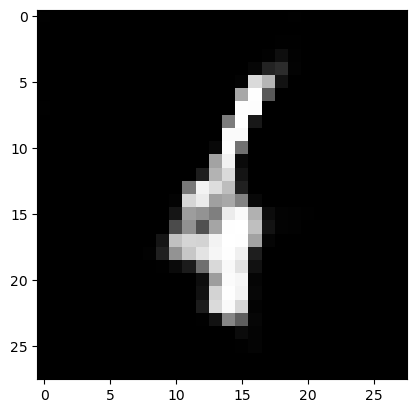

In [22]:
plt.imshow(generator(np.random.randn(1,100)).reshape(28,28),cmap='gray')


In [23]:
a = np.random.randn(2,100)
a.shape

(2, 100)

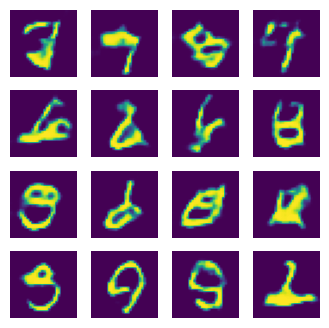

In [24]:
# Save the generator weights to a file
generator.save_weights('generator_weights.h5')

# Load the generator weights from the file
generator.load_weights('generator_weights.h5')

# Generate some fake images using the trained generator
noise = tf.random.normal([num_examples_to_generate, noise_dim])
generated_images = generator(noise, training=False)

# Plot the generated images
fig = plt.figure(figsize=(4,4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow((generated_images[i]*0.5 + 0.5).numpy())
    plt.axis('off')
plt.show()